In [3]:
import torch
from GPT2_Functions import GPTModel

In [4]:
GPT_CONFIG_124M = {
    #1 Vocabulary size
    "vocab_size": 50257,          
    #2 Shortened context length (orig: 1024)
    "context_length": 256,
    #3 Embedding dimension        
    "emb_dim": 768,
    #4 Number of attention heads           
    "n_heads": 12,
    #5 Number of layers            
    "n_layers": 12,
    #6 Dropout rate           
    "drop_rate": 0.1,
    #7 Query-key-value bias         
    "qkv_bias": False         
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768, padding_idx=768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): L

In [5]:
import os
import urllib.request

file_path = "the-verdict.txt"

url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/"
    "main/ch02/01_main-chapter-code/the-verdict.txt"
)

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [6]:
import tiktoken
from torch.utils.data import Dataset, DataLoader

class GPTDatasetv1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt) #1
        
        # The stride setting dictates the number of positions the inputs shift across batches, 
        #   emulating a sliding window approach
        for i in range(0, len(token_ids) - max_length, stride): #2
            input_chunk = token_ids[i:i + max_length]
            target_chunck = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunck))
    
    def __len__(self):  #3
        return len(self.input_ids)
    
    def __getitem__(self, idx):     #4
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")                         #1
    dataset = GPTDatasetv1(txt, tokenizer, max_length, stride)   #2
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,     #3
        num_workers=num_workers     #4
    )

    return dataloader

In [7]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    text_data[:split_idx],
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    text_data[split_idx:],
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

## Learning rate warmup

Implementing a learning rate warmup can stabilize the training of complex models such as LLMs. This process involves gradually increasing the learning rate from a very low initial value (initial_lr) to a maximum value specified by the user (peak_lr). Starting the training with smaller weight updates decreases the risk of the model encountering large, destabilizing updates during its training phase.

In [8]:
n_epochs = 15
initial_lr = 0.0001
peak_lr = 0.01
warmup_setps = 20

In [9]:
total_steps = len(train_loader) * n_epochs
#1 20% warmup
warmup_steps = int(0.2 * total_steps)
print(warmup_setps)

20


In [10]:
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)
# 1 This increment is determined by how much we increase the inital_lr in each of the 20 warmup steps.
lr_increment = (peak_lr - initial_lr) / warmup_setps

global_step = -1
track_lrs = []

# 2 Executes a typical training loop iterating over the batches in the training loader in each epoch
for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1

        if global_step < warmup_setps:
            # 3 Updates the learning rate if we are still in the warmup phase
            lr = initial_lr + global_step * lr_increment
        else:
            lr = peak_lr
        
        # 4 Applies the calculated learning rate to the optimizer
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
            
        # 5 In a complete training loop, the loss and the model updates would be calculated, 
        # which are omitted here for simplicity.
        track_lrs.append(optimizer.param_groups[0]["lr"])

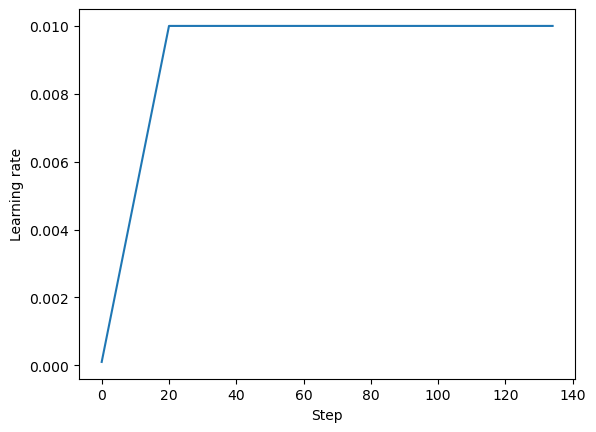

In [11]:
import matplotlib.pyplot as plt

plt.ylabel("Learning rate")
plt.xlabel("Step")
total_training_steps = len(train_loader) * n_epochs
plt.plot(range(total_training_steps), track_lrs);
plt.show()

The learning rate warmup increases the learning rate for the first 20 training steps. After 20 steps, the learning rate reaches the peak of 0.01 and remains constant for the rest of the training.

## Cosine decay

Another widely adopted technique for training complex deep neural networks and LLMs is cosine decay. This method modulates the learning rate throughout the training epochs, making it follow a cosine curve after the warmup stage.

In its popular variant, cosine decay reduces (or decays) the learning rate to nearly zero, mimicking the trajectory of a half-cosine cycle. The gradual learning decrease in cosine decay aims to decelerate the pace at which the model updates its weights. This is particularly important because it helps minimize the risk of overshooting the loss minima during the training process, which is essential for ensuring the stability of the training during its later phases.

In [12]:
import math

min_lr = 0.1 * initial_lr
track_lrs = []
lr_increment = (peak_lr - initial_lr) / warmup_setps
global_step = -1

for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1

        # 1 Applies linear warmup
        if global_step < warmup_setps:
            lr = initial_lr + global_step * lr_increment
        else:
            # 2 Uses cosine annealing after warmup
            progress = (
                (global_step - warmup_setps) / 
                (total_training_steps - warmup_setps)
            )

            lr = min_lr + (peak_lr - min_lr) * 0.5 * (
                1 + math.cos(math.pi * progress)
            )
        
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

        track_lrs.append(optimizer.param_groups[0]["lr"])

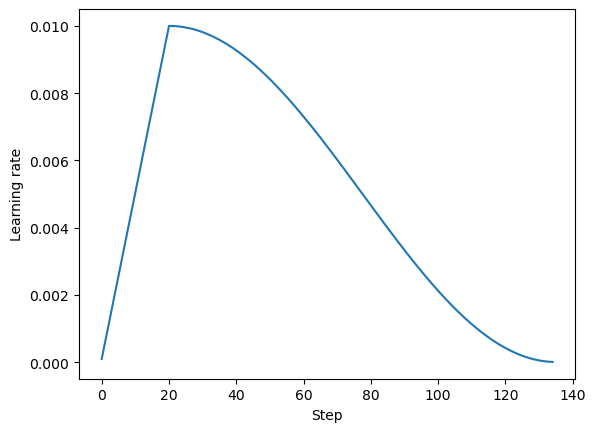

In [13]:
plt.ylabel("Learning rate")
plt.xlabel("Step")
plt.plot(range(total_training_steps), track_lrs)
plt.show()

The first 20 steps of linear learning rate warmup are followed by a cosine decay, which reduces the learning rate in a half-cosine cycle until it reaches its minimum point at the end of training.

## Gradient clipping

Gradient clipping is another important technique for enhancing stability during LLM training. This method involves setting a threshold above which gradients are downscaled to a predetermined maximum magnitude. This process ensures that the updates to the model’s parameters during backpropagation stay within a manageable range.

In [14]:
from GPT2_Functions import calc_loss_batch

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
loss = calc_loss_batch(input_batch, target_batch, model, device)
loss.backward()

In [15]:
def find_highest_gradient(model):
    max_grad = None
    for param in model.parameters():
        if param.grad is not None:
            grad_values = param.grad.data.flatten()
            max_grad_param = grad_values.max()

            if max_grad is None or max_grad_param > max_grad:
                max_grad = max_grad_param
    return max_grad

print(find_highest_gradient(model))

tensor(0.0457, device='cuda:0')


In [16]:
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
print(find_highest_gradient(model))

tensor(0.0206, device='cuda:0')


## The modified training function

In [17]:
from GPT2_Functions import evaluate_model, generate_and_print_sample

In [22]:
def train_model(model, train_loader, val_loader, optimizer, device,
                n_epochs, eval_freq, eval_iter, start_context, tokenizer,
                warmup_steps, initial_lr=3e-05, min_lr=1e-6):

    train_losses, val_losses, track_tokens_seen, track_lrs = [], [], [], []
    tokens_seen, global_step = 0, -1

    # 1 Retrieves the initial learning rate from the optimizer, assuming we use it as the peak learning rate
    peak_lr = optimizer.param_groups[0]["lr"]

    #2 Calculates the total number of iterations in the training process
    total_training_steps = len(train_loader) * n_epochs

    #3 Calculates the learning rate increment during the warmup phase
    lr_increment = (peak_lr - initial_lr) / warmup_steps

    for epoch in range(n_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            global_step += 1
            
            #4 Adjusts the learning rate based on the current phase (warmup or cosine annealing)
            if global_step < warmup_steps:
                lr = initial_lr + global_step * lr_increment  
            else:
                progress = ((global_step - warmup_steps) / 
                            (total_training_steps - warmup_steps))
                lr = min_lr + (peak_lr - min_lr) * 0.5 * (
                    1 + math.cos(math.pi * progress))

            #5 Applies the calculated learning rate to the optimizer
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr
            track_lrs.append(lr)
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()

            #6 Applies gradient clipping after the warmup phase to avoid exploding gradients
            if global_step > warmup_steps:
                torch.nn.utils.clip_grad_norm_(
                    model.parameters(), max_norm=1.0
                )
            
            #7 Everything below here remains unchanged compared to the train_model_simple function used in chapter 5.
            optimizer.step() 
            tokens_seen += input_batch.numel()

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader,
                    device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Iter {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )


        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen, track_lrs

In [23]:
import tiktoken

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
peak_lr = 5e-4
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)
tokenizer = tiktoken.get_encoding("gpt2")

n_epochs = 15
train_losses, val_losses, tokens_seen, lrs = train_model(
    model, train_loader, val_loader, optimizer, device, n_epochs=n_epochs,
    eval_freq=5, eval_iter=1, start_context="Every effort moves you",
    tokenizer=tokenizer, warmup_steps=warmup_steps, 
    initial_lr=1e-5, min_lr=1e-5
)

Ep 1 (Iter 000000): Train loss 10.969, Val loss 10.938
Ep 1 (Iter 000005): Train loss 9.339, Val loss 9.463
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Iter 000010): Train loss 7.823, Val loss 8.190
Ep 2 (Iter 000015): Train loss 6.342, Val loss 6.893
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 3 (Iter 000020): Train loss 6.084, Val loss 6.597
Ep 3 (Iter 000025): Train loss 5.669, Val loss 6.798
Every effort moves you, the, the of the, the, the, the of the of the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the
Ep 4 (Iter 000030): Train loss 5.843, Val loss 6.845
Ep 4 (Iter 000035): Train loss 6.081, Val loss 7.078
Every effort moves you aisis a G                                             
Ep 5 (Iter 000040): Train loss 5.621, Val loss 6.857
Every effort moves you.  --, the, the, the,, the, the, the, the--,, the, the, the,, the, the, the, the, the, the,,,, the,,,, the
Ep 6 (Iter 000